In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import hiddenlayer as hl
import time

import seaborn as sns
from matplotlib import pyplot as plt

import os
dir_path = os.getcwd()

In [2]:
dir_path

'/Users/clause/OneDrive/Documents/CNN_RUL/data'

In [3]:
N_EPOCH = 200
Learning_Rate = 0.01
L2_Reg = 0.001

In [4]:
load_data = 1

In [5]:
# Column names
index_names = ['id', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

# ead data
train_raw = pd.read_csv((dir_path + f'/train_FD00{load_data}.txt'), sep='\s+', header=None, names=col_names)
test_raw = pd.read_csv((dir_path + f'/test_FD00{load_data}.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path + f'/RUL_FD00{load_data}.txt'), sep='\s+', header=None, names=['RUL']).to_numpy()

grouped_by_id, grouped_by_id_t = train_raw.groupby(by="id"), test_raw.groupby(by="id")
    
max_cycle, max_cycle_t = grouped_by_id["time_cycles"].max().to_numpy(), grouped_by_id_t["time_cycles"].max().to_numpy()

In [6]:
train_raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
time_cycles,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s_1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


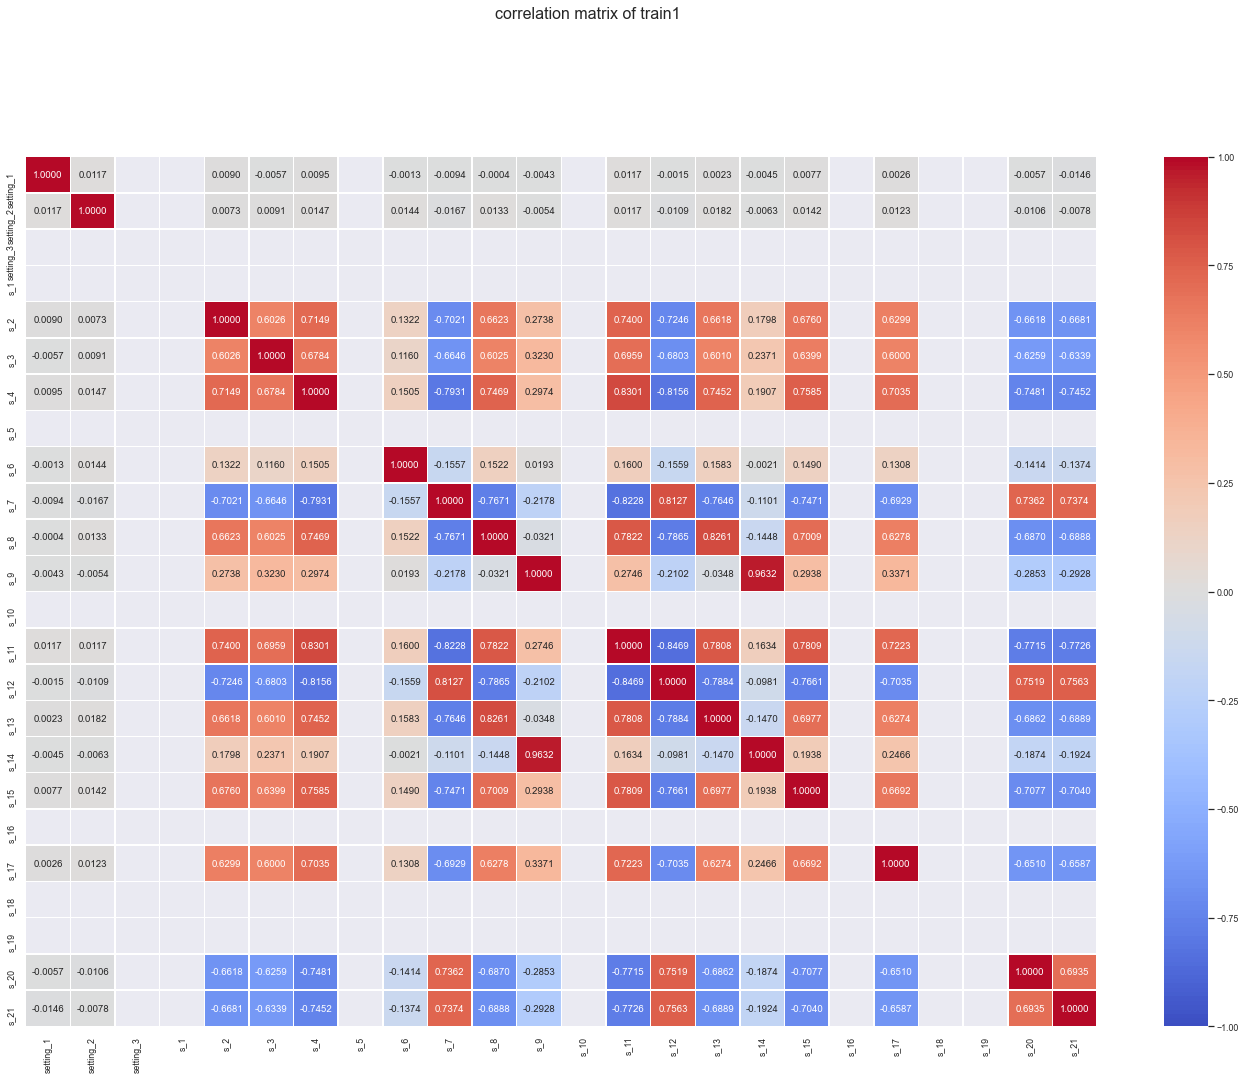

In [7]:
df_corr = train_raw.drop(columns=["id","time_cycles"]).corr()

# correlation matrix
sns.set(font_scale=0.8)
plt.figure(figsize=(24,16))
sns.heatmap(df_corr, annot=True, fmt=".4f",vmin=-1, vmax=1, linewidths=.5, cmap = sns.color_palette("coolwarm", 200))

plt.figtext(.45, 1,f'correlation matrix of train{load_data}', fontsize=16, ha='center')
plt.xticks(rotation=90)
plt.show()

In [8]:
# From others' report, only for FD001
# 18 & 19 because of std = 0, 1, 5, 10, 16 because of similarity
# So, remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9','s_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
setting_names = ['setting_1', 'setting_2', 'setting_3']
drop_sensors = ['s_1', 's_5', 's_10', 's_16', 's_18', 's_19']
drop_labels = setting_names + drop_sensors
train_raw.drop(labels=drop_labels, axis=1, inplace=True)
test_raw.drop(labels=drop_labels, axis=1, inplace=True)

In [9]:
print({i.shape for i in [train_raw, test_raw, max_cycle, y_test, max_cycle_t]}) 

{(100, 1), (20631, 17), (13096, 17), (100,)}


In [10]:
train_raw

,id,time_cycles,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1,1,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,100,197,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,100,198,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,100,199,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


In [11]:
# Scale
def Stan_Scaler(train_raw, test_raw):
    ss = StandardScaler()

    X = train_raw.iloc[:, 2:]
    idx = train_raw.iloc[:, 0:2].to_numpy()
    X_ss = ss.fit_transform(X)

    X_t = test_raw.iloc[:, 2:]
    idx_t = test_raw.iloc[:, 0:2].to_numpy()
    Xt_ss = ss.fit_transform(X_t)

    nf = X_ss.shape[1]
    ns = X_ss.shape[0]
    ns_t = Xt_ss.shape[0]

    return X_ss, idx, Xt_ss, idx_t, nf, ns, ns_t

In [12]:
# Standard Scalar for X_train and X_test, but maintain id of them.
# Get #feature & #series of train & test, get 

X_ss, idx, Xt_ss, idx_t, nf, ns, ns_t = Stan_Scaler(train_raw, test_raw)

In [13]:
print(X_ss.shape, idx.shape, Xt_ss.shape, idx_t.shape, nf, ns, ns_t)

(20631, 15) (20631, 2) (13096, 15) (13096, 2) 15 20631 13096


In [14]:
def target_rul(max_cycle, cycle, func):

    if func == "linear":
        target = min(max_cycle - cycle, 130)
    else:
        target = 100

    return target

In [15]:
def prepare(max_cycle, idx, idx_t, X_ss, Xt_ss, calcul, nf, ns, ns_t, lenth = 15):

    train_img = []
    test_img = []
    train_y = []
    id_engine = 1
    id_engine_t = 1
    i = 0
    i_t = 0
    id_engine_end = max_cycle[id_engine - 1] - 1
    id_engine_start = 0

    while i <= ns - lenth:

        img = X_ss[i:i + lenth, ]
        img = img.astype('float32')
        train_img.append(img)
        train_y.append(target_rul(max_cycle[id_engine - 1], idx[i + 14, 1], calcul))
        i = i + 1
        if i + 14 <= ns - 1 and int(idx[i + 14, 0]) != id_engine:
            id_engine_start += max_cycle[id_engine - 1]
            i = i + 14
            id_engine += 1
            id_engine_end += max_cycle[id_engine - 1]
    
    while i_t <= ns_t - lenth:
        img_t = Xt_ss[i_t:i_t + lenth, ]
        img_t = img_t.astype('float32')
        test_img.append(img_t)
        i_t = i_t + 1
        if i_t + 14 <= ns_t - 1:
            if int(idx_t[i_t + 14, 0]) != id_engine_t:
                i_t = i_t + 14
                id_engine_t += 1

    # converting training images into torch format
    train_x = np.array(train_img)
    train_x = train_x.reshape(train_x.shape[0], 1, 15, nf)
    train_x = torch.from_numpy(train_x)
    
    test_x = np.array(test_img)
    test_x = test_x.reshape(test_x.shape[0], 1, 15, nf)
    test_x = torch.from_numpy(test_x)

    # converting the target into torch format
    train_y = np.array(train_y)
    train_y = train_y.astype(int)
    train_y = torch.from_numpy(train_y)

    return train_x, train_y, test_x 

In [16]:
train_x, train_y, test_x = prepare(max_cycle, idx, idx_t, X_ss, Xt_ss, "linear", nf, ns, ns_t)

In [17]:
train_y

tensor([130, 130, 130,  ...,   2,   1,   0])

In [18]:
print(train_x.shape, train_y.shape, test_x.shape)

torch.Size([19231, 1, 15, 15]) torch.Size([19231]) torch.Size([11696, 1, 15, 15])


In [19]:
class CNN_MLP(nn.Module):
    def __init__(self, nf):
        super(CNN_MLP, self).__init__()

        self.cnn = nn.Sequential(
            
            nn.Conv2d(1, 8, kernel_size=(4, nf), stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=(2, 1), stride=2),
            
            nn.Conv2d(8, 14, kernel_size=(3, 1), stride=1),
            nn.BatchNorm2d(14),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=(2, 1), stride=2),
        )

        self.fc = nn.Sequential(
            nn.Linear(14 * 2 * 1, 131),
            #nn.BatchNorm1d(131),
            #nn.ReLU(),
            #nn.Linear(131,1)
        )

    # Defining the forward pass
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
model = CNN_MLP(nf)

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.
/Users/clause/Anaconda/anaconda3/envs/ML/lib/python3.8/site-packages/torch/onnx/symbolic_helper.py:712: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  warnings.warn("ONNX export mode is set to " + training_mode +


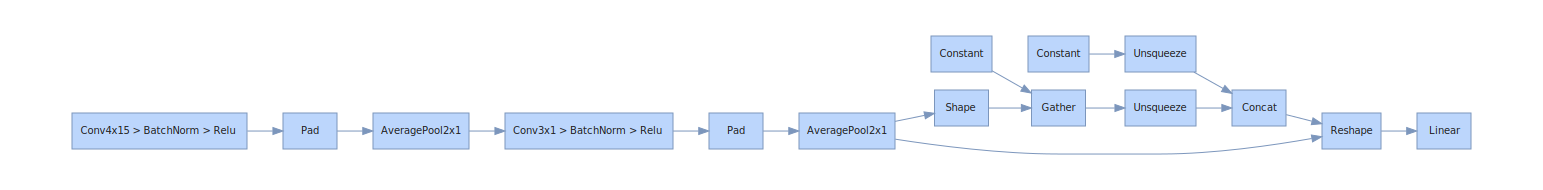

In [20]:
# Need graphviz
#!sudo yum install graphviz

vis_graph = hl.build_graph(model, torch.zeros([1 ,1, 15, 15]))
vis_graph.theme = hl.graph.THEMES["blue"].copy() 
vis_graph

In [21]:
vis_graph.save("./cnn.png") 

In [22]:
optimizer = optim.Adam(model.parameters(), lr = Learning_Rate, weight_decay = L2_Reg)
criterion = nn.CrossEntropyLoss()

In [23]:
def train(n_epochs, model, train_x, train_y, test_x, max_cycle_t, y_test):
    rmse_history = []
    history = hl.History()
    canvas = hl.Canvas()
    log_step_interval = 100
    
    for epoch in range(1, n_epochs + 1):
        model.train()

        x_train, y_train = Variable(train_x), Variable(train_y)
        optimizer.zero_grad()
        output_train = model(x_train)
        loss = criterion(output_train, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0:
            # prediction on testing dataset
            pred = test_prediction(model, test_x)
            # evaluate the prediction accuracy
            _, rmse, score = scoring(pred, max_cycle_t, y_test)
            rmse_history.append(rmse)
            
            history.log((epoch),
                        train_loss = round(loss.item(), 3),
                        test_rmse = rmse,
                        test_score = score,
                        hidden_weight = model.fc[0].weight,
                        conv_weight=model.cnn[0].weight)
            
            with canvas:
                canvas.draw_plot(history["train_loss"])
                canvas.draw_plot(history["test_rmse"])
                canvas.draw_plot(history["test_score"])
                canvas.draw_image(history["hidden_weight"])
                canvas.draw_hist(history["conv_weight"])

    return rmse_history     

In [24]:
def test_prediction(model, test_x):
    # generating predictions for test set
    with torch.no_grad():
        output = model(test_x)

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)

    return predictions

In [25]:
def scoring(predictions, max_cycle_t, y_test):
    result = []
    ix = 1
    k = 0
    while k < 100:
        result.append((predictions[max_cycle_t[k] + ix - 15 - 1]))
        # t = max_cycle_t[k] + ix - 15 - 1
        ix = max_cycle_t[k] + ix - 14
        k += 1

    j = 0
    rmse = 0
    score = 0
    while j < 100:
        h = result[j] - y_test[j]
        rmse = rmse + pow(h, 2)
        if h < 0:
            score += np.exp(-h / 13) - 1
        else:
            score += np.exp(h / 10) - 1
        j += 1

    rmse = np.sqrt(rmse / 100)
    rmse, score = round(rmse.item()), round(score.item())
    return result, rmse, score

In [ ]:
training = train(N_EPOCH, model, train_x, train_y, test_x, max_cycle_t, y_test)
predictions = test_prediction(model, test_x)
result, rmse, score = scoring(predictions, max_cycle_t, y_test)

/Users/clause/Anaconda/anaconda3/envs/ML/lib/python3.8/site-packages/hiddenlayer/canvas.py:218: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self.figure.add_subplot(self.gs, projection="3d")
/Users/clause/Anaconda/anaconda3/envs/ML/lib/python3.8/site-packages/hiddenlayer/canvas.py:255: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(metric.formatted_steps[-limit:])


In [ ]:
print(f'Last epoch RMSE = {rmse}, Score = {score}')

In [ ]:
plt.figure(figsize=(20, 6))  # plotting
plt.axvline(x=100, c='r', linestyle='--')  # size of the training set
plt.plot(y_test, 'g', label='Actual Data')  # actual plot
plt.plot(result, 'r', label='Predicted Data')  # predicted plot
plt.title('Remaining Useful Life Prediction')
plt.legend()
plt.show()